# Task 3: Baseline Model Comparison (Logistic Regression)

In this notebook, you will train a Logistic Regression model to predict the `prior_hiring_decision` target variable. You will also begin your fairness analysis by establishing a baseline for accuracy and fairness metrics.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

### **Equalized Odds**


In [2]:
def equalized_odds(data, pred_col='prediction', true_col='prior_hiring_decision'):
    """
    Compute equalized odds for binary race (white=1 vs non-white=anything else).
    TPR = P(pred=1 | true=1), FPR = P(pred=1 | true=0)
    """
    data = data.copy()
    data['_race_binary'] = (data['Race'] == 1).astype(int)
    
    tpr_rates = []
    fpr_rates = []
    
    for race in [0, 1]:  # 0=non-white, 1=white
        group_data = data[data['_race_binary'] == race]
        
        # Actual positives and negatives
        actual_positives = group_data[group_data[true_col] == 1]
        actual_negatives = group_data[group_data[true_col] == 0]
        
        # TPR: of actual positives, how many predicted positive?
        if len(actual_positives) > 0:
            tpr = actual_positives[pred_col].mean()
            tpr_rates.append(tpr)
        
        # FPR: of actual negatives, how many predicted positive?
        if len(actual_negatives) > 0:
            fpr = actual_negatives[pred_col].mean()
            fpr_rates.append(fpr)
    
    max_tpr, min_tpr = max(tpr_rates), min(tpr_rates)
    max_fpr, min_fpr = max(fpr_rates), min(fpr_rates)
    
    tpr_ratio = float('inf') if min_tpr == 0 else max_tpr / min_tpr
    fpr_ratio = float('inf') if min_fpr == 0 else max_fpr / min_fpr
    
    return max(tpr_ratio, fpr_ratio)

In [6]:

# Load Data
train_df = pd.read_csv('../data/train.csv')
val_df = pd.read_csv('../data/val.csv')
test_df = pd.read_csv('../data/test.csv')

# Configuration: Toggle between weighted and unweighted training
USE_WEIGHTED = True  # Set to False for unweighted training

columns_to_drop = ["Hours_Per_Week", "Marital_Status", "Relationship"]
protected_characteristics = ["Sex", "Race", "Age", "Place_Of_Birth"]
target = 'prior_hiring_decision'

# Drop columns_to_drop
for df in [train_df, val_df, test_df]:
    df.drop(columns=columns_to_drop, inplace=True)

print(f"Training mode: {'WEIGHTED' if USE_WEIGHTED else 'UNWEIGHTED'}")
print("Training Shape:", train_df.shape)

Training mode: WEIGHTED
Training Shape: (30000, 10)


## 1. Preprocessing

In [7]:
# Target column is already defined
print(f"Target: {target}")
print(f"Columns in train_df: {list(train_df.columns)}")

Target: prior_hiring_decision
Columns in train_df: ['Age', 'Workclass', 'Education', 'Occupation', 'Sex', 'Race', 'Place_Of_Birth', 'interview_score', 'cv_assessment_score', 'prior_hiring_decision']


## 2. Preprocessing Fairness

In [8]:
def compute_group_weights(df, label_col):
    """
    Compute rebalancing weights for each (race_binary, label) combination.
    Returns a dictionary mapping (race_binary, label) -> weight.
    
    Weight formula: w = P(race) * P(label) / P(race, label)
    This makes race and label independent in the weighted distribution.
    """
    total = len(df)
    labels = df[label_col].unique()
    
    # Binary race: 1 = white, 0 = non-white
    race_binary = (df['Race'] == 1).astype(int)
    
    weights = {}
    for race in [0, 1]:
        race_count = (race_binary == race).sum()
        for label in labels:
            label_count = (df[label_col] == label).sum()
            intersection_count = ((race_binary == race) & (df[label_col] == label)).sum()
            
            if intersection_count > 0:
                # w = P(race) * P(label) / P(race, label)
                weight = (race_count * label_count) / (total * intersection_count)
            else:
                weight = 1.0
            
            weights[(race, int(label))] = float(weight)
    
    return weights


def get_sample_weights(df, group_weights, label_col):
    """
    Get per-sample weights array for use in loss function.
    """
    race_binary = (df['Race'] == 1).astype(int)
    sample_weights = [
        group_weights.get((race, int(label)), 1.0)
        for race, label in zip(race_binary, df[label_col])
    ]
    return np.array(sample_weights)


# Compute group weights from training data
group_weights = compute_group_weights(train_df, target)

print("Group Weights (applied to loss function):")
print("  Formula: w = P(race) * P(label) / P(race, label)")
print()
for (race, label), weight in sorted(group_weights.items()):
    race_name = "white" if race == 1 else "non-white"
    label_name = "hired" if label == 1 else "not hired"
    print(f"  {race_name}, {label_name}: {weight:.4f}")

Group Weights (applied to loss function):
  Formula: w = P(race) * P(label) / P(race, label)

  non-white, not hired: 0.8388
  non-white, hired: 1.2625
  white, not hired: 1.1321
  white, hired: 0.8879


## 3. Training

In [9]:
# 1. Prepare sample weights
if USE_WEIGHTED:
    sample_weights = get_sample_weights(train_df, group_weights, target)
else:
    sample_weights = None

# 2. Define features and split
cols_to_exclude = protected_characteristics + [target]
features = [col for col in train_df.columns if col not in cols_to_exclude]

X_train, y_train = train_df[features], train_df[target]
X_val, y_val = val_df[features], val_df[target]
X_test, y_test = test_df[features], test_df[target]

print(f"Features: {features}")
print(f"X_train shape: {X_train.shape}")

# 3. Preprocessing pipeline
categorical_cols = [col for col in ['Workclass', 'Education', 'Occupation'] if col in features]
numerical_cols = [col for col in features if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

# Preprocess data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# 4. Simple grid search with max 4 configs
param_configs = [
    {'C': 0.1, 'penalty': 'l2'},
    {'C': 1.0, 'penalty': 'l2'},
    {'C': 0.1, 'penalty': 'l1'},
    {'C': 1.0, 'penalty': 'l1'},
]

print(f"\nTraining with {'SAMPLE WEIGHTS' if USE_WEIGHTED else 'NO WEIGHTS'}...")
print(f"Testing {len(param_configs)} configurations...\n")

best_score = 0
best_params = {}
best_clf = None

for params in param_configs:
    clf = LogisticRegression(**params, solver='saga', max_iter=1000, random_state=42)
    clf.fit(X_train_processed, y_train, sample_weight=sample_weights)
    score = clf.score(X_val_processed, y_val)
    
    if score > best_score:
        best_score = score
        best_params = params
        best_clf = clf

print(f"Best params: {best_params}")
print(f"Best validation accuracy: {best_score:.4f}")

Features: ['Workclass', 'Education', 'Occupation', 'interview_score', 'cv_assessment_score']
X_train shape: (30000, 5)

Training with SAMPLE WEIGHTS...
Testing 4 configurations...

Best params: {'C': 0.1, 'penalty': 'l1'}
Best validation accuracy: 0.7369


## 4. Evaluation

In [10]:
y_pred = best_clf.predict(X_test_processed)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.7359
Confusion Matrix:
[[3883 1347]
 [1294 3476]]


## 5. Fairness Metric Implementation

In [11]:
val_with_preds = val_df.copy()
val_with_preds['prediction'] = best_clf.predict(X_val_processed)

# Compute equalized odds for binary race (white vs non-white)
eo_ratio = equalized_odds(val_with_preds, pred_col='prediction', true_col=target)

# Get detailed TPR/FPR by group
val_with_preds['_race_binary'] = (val_with_preds['Race'] == 1).astype(int)
results = {}
for race in [0, 1]:
    group_data = val_with_preds[val_with_preds['_race_binary'] == race]
    
    # Actual positives and negatives (based on true label)
    actual_positives = group_data[group_data[target] == 1]
    actual_negatives = group_data[group_data[target] == 0]
    
    race_name = "white" if race == 1 else "non-white"
    results[race_name] = {
        'tpr': float(actual_positives['prediction'].mean()) if len(actual_positives) > 0 else None,
        'fpr': float(actual_negatives['prediction'].mean()) if len(actual_negatives) > 0 else None,
        'count': len(group_data)
    }

print("Fairness Metrics (Logistic Regression) - Binary Race:")
print(f"\nEqualized Odds Ratio: {eo_ratio:.4f}")
print("\nBy Group:")
for group, metrics in results.items():
    print(f"  {group}: TPR={metrics['tpr']:.4f}, FPR={metrics['fpr']:.4f}, Count={metrics['count']}")

Fairness Metrics (Logistic Regression) - Binary Race:

Equalized Odds Ratio: 1.8534

By Group:
  non-white: TPR=0.6175, FPR=0.1628, Count=3756
  white: TPR=0.7551, FPR=0.3017, Count=6244


## 6. ROC Curve Analysis

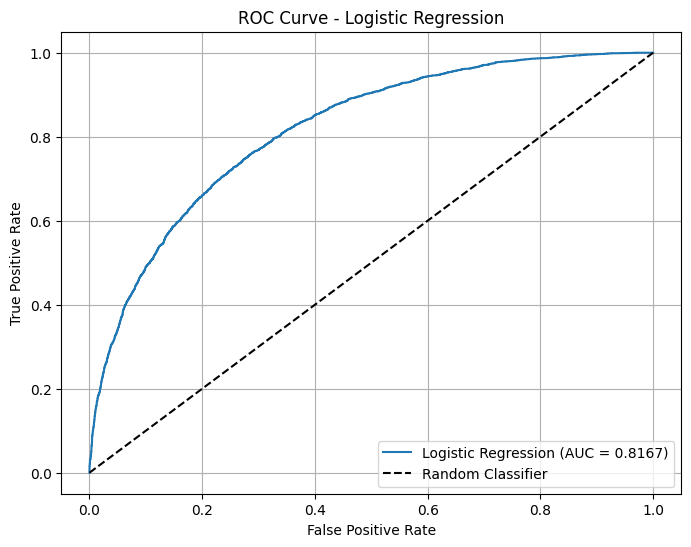

AUC Score: 0.8167


In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_proba = best_clf.predict_proba(X_test_processed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig(f'../data/lr_roc_{weight}.png')
plt.show()
weight = "weighted" if USE_WEIGHTED else "unweighted"

print(f"AUC Score: {auc_score:.4f}")

## 7. Adjusted Equalized Odds

In [14]:
def adjusted_equalized_odds(data, y_true_col, y_proba, thresholds):
    """
    Calculate equalized odds using group-specific classification thresholds.
    Uses binary race: white (Race==1) vs non-white (Race!=1).
    
    Args:
        data: DataFrame with Race column and true labels
        y_true_col: Name of true label column
        y_proba: Array of predicted probabilities
        thresholds: Dict mapping race_binary (0 or 1) to classification threshold
                    e.g., {0: 0.4, 1: 0.6} means non-white uses 0.4, white uses 0.6
    
    Returns:
        Dict with TPR/FPR per group and equalized odds ratio
    """
    data = data.copy()
    data['y_proba'] = y_proba
    data['_race_binary'] = (data['Race'] == 1).astype(int)
    
    # Apply group-specific thresholds
    data['adjusted_pred'] = data.apply(
        lambda row: 1 if row['y_proba'] >= thresholds.get(row['_race_binary'], 0.5) else 0,
        axis=1
    )
    
    tpr_rates = []
    fpr_rates = []
    results = {}
    
    for race in [0, 1]:  # 0=non-white, 1=white
        group_data = data[data['_race_binary'] == race]
        actual_positives = group_data[group_data[y_true_col] == 1]
        actual_negatives = group_data[group_data[y_true_col] == 0]
        
        tpr = actual_positives['adjusted_pred'].mean() if len(actual_positives) > 0 else 0
        fpr = actual_negatives['adjusted_pred'].mean() if len(actual_negatives) > 0 else 0
        
        tpr_rates.append(tpr)
        fpr_rates.append(fpr)
        
        race_name = "white" if race == 1 else "non-white"
        results[race_name] = {
            'tpr': float(tpr),
            'fpr': float(fpr),
            'threshold': float(thresholds.get(race, 0.5)),
            'count': int(len(group_data))
        }
    
    max_tpr, min_tpr = max(tpr_rates), min(tpr_rates)
    max_fpr, min_fpr = max(fpr_rates), min(fpr_rates)
    
    tpr_ratio = max_tpr / min_tpr if min_tpr > 0 else float('inf')
    fpr_ratio = max_fpr / min_fpr if min_fpr > 0 else float('inf')
    
    results['tpr_ratio'] = float(tpr_ratio)
    results['fpr_ratio'] = float(fpr_ratio)
    results['equalized_odds_ratio'] = float(max(tpr_ratio, fpr_ratio))
    
    return results

In [ ]:
# Get predicted probabilities on validation set
y_proba_val = best_clf.predict_proba(X_val_processed)[:, 1]

# Define group-specific thresholds to try to equalize odds
# Key: 0 = non-white, 1 = white
thresholds = {
    0: 0.31,  # lower threshold for non-white (increases their TPR)
    1: 0.5   # standard threshold for white
}

# Compute adjusted equalized odds
results = adjusted_equalized_odds(val_df, target, y_proba_val, thresholds)

# Calculate accuracy with adjusted thresholds
val_with_adjusted = val_df.copy()
val_with_adjusted['_race_binary'] = (val_with_adjusted['Race'] == 1).astype(int)
val_with_adjusted['adjusted_pred'] = [
    1 if prob >= thresholds[race] else 0 
    for prob, race in zip(y_proba_val, val_with_adjusted['_race_binary'])
]
adjusted_accuracy = accuracy_score(val_with_adjusted[target], val_with_adjusted['adjusted_pred'])

print("Adjusted Equalized Odds (with group-specific thresholds):")
print(f"\nThresholds: non-white={thresholds[0]}, white={thresholds[1]}")
print(f"\nAccuracy: {adjusted_accuracy:.4f}")
print(f"Equalized Odds Ratio: {results['equalized_odds_ratio']:.4f}")
print(f"TPR Ratio: {results['tpr_ratio']:.4f}")
print(f"FPR Ratio: {results['fpr_ratio']:.4f}")
print("\nBy Group:")
for group in ['non-white', 'white']:
    m = results[group]
    print(f"  {group}: TPR={m['tpr']:.4f}, FPR={m['fpr']:.4f}, threshold={m['threshold']}, count={m['count']}")

Adjusted Equalized Odds (with group-specific thresholds):

Thresholds: non-white=0.3, white=0.5

Accuracy: 0.7229
Equalized Odds Ratio: 1.2478
TPR Ratio: 1.1288
FPR Ratio: 1.2478

By Group:
  non-white: TPR=0.8524, FPR=0.3765, threshold=0.3, count=3756
  white: TPR=0.7551, FPR=0.3017, threshold=0.5, count=6244
